In [18]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [19]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48, 1))  # 灰階圖的channel數為1
        image_array[i] = image

    return image_array, image_label


def plot_one_emotion(data, img_arrays, img_labels, label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace=.2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion'] == label].index[i]
        axs[i].imshow(img_arrays[idx][:, :, 0], cmap='gray')
        axs[i].set_title(emotions[img_labels[idx]])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])


def plot_conv_feature(data, img_arrays, img_labels, label = 0):
    fig, axs = plt.subplots(4, 4, figsize=(16, 16))
    fig.subplots_adjust(hspace=.2, wspace=.2)
    axs = axs.flatten()
    for i in range(16):
        idx = data[data['cluster'] == label].index[i]
        axs[i].imshow(img_arrays[idx], cmap='gray')
        axs[i].set_title(f"feature {i}, cluster {label}", size = 20)
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])


def convert_to_3_channels(img_arrays):
    sample_size, nrows, ncols, c = img_arrays.shape
    img_stack_arrays = np.zeros((sample_size, nrows, ncols, 3))
    for _ in range(sample_size):
        img_stack = np.stack(
            [img_arrays[_][:, :, 0], img_arrays[_][:, :, 0], img_arrays[_][:, :, 0]], axis=-1)
        img_stack_arrays[_] = img_stack/255
    return img_stack_arrays


emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear',
            3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [20]:
df_raw = pd.read_csv("D:/mycodes/AIFER/data/fer2013.csv")
df_train = df_raw[df_raw['Usage'] == 'Training']
X_train, y_train = prepare_data(df_train)
X_train = convert_to_3_channels(X_train)  # 轉成3維
y_train_oh = to_categorical(y_train)

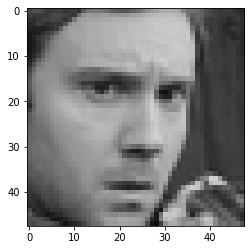

In [21]:
plt.imshow(X_train[0],cmap='gray')

In [22]:
efn = EfficientNetB0(include_top=False, weights='imagenet',
                     input_tensor=None, input_shape=(48, 48, 3),
                     pooling='max', classifier_activation='softmax')

block1_conv_model = tf.keras.Model(efn.inputs, efn.get_layer(name='block2a_expand_conv').output)
b1_result = block1_conv_model(X_train[0]).numpy()
print(b1_result.shape)

(1, 24, 24, 96)


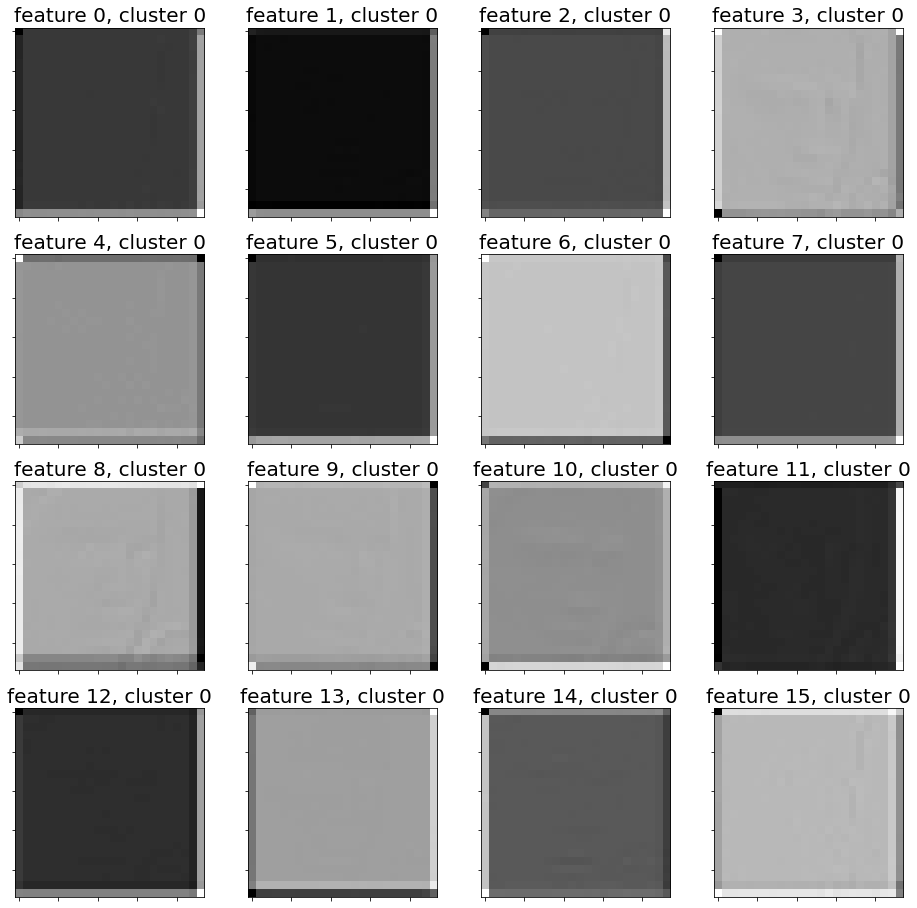

In [23]:
X_features = np.array([ b1_result[0,:,:,i] for i in range(96)])
y_features = np.array([0  for i in range(96)])
feature_data = pd.DataFrame({"cluster":y_features})
plot_conv_feature(feature_data,X_features, y_features)

In [24]:
top_conv_model = tf.keras.Model(efn.inputs, efn.get_layer(name='top_conv').output)
top_result = top_conv_model(X_train[0]).numpy()
print(top_result.shape)

(1, 2, 2, 1280)


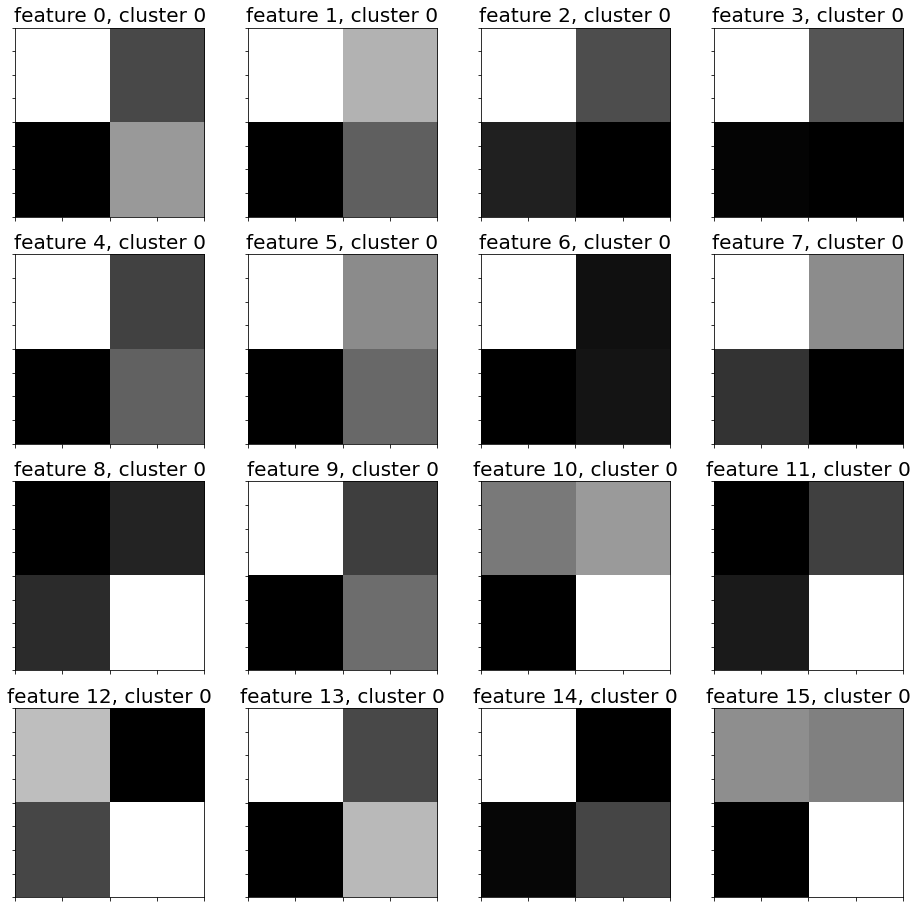

In [25]:
X_features = np.array([ top_result[0,:,:,i] for i in range(1280)])
y_features = np.array([0  for i in range(1280)])
feature_data = pd.DataFrame({"cluster":y_features})
plot_conv_feature(feature_data,X_features, y_features)

In [26]:
sample_size, nrows, ncols = X_features.shape
X = X_features.reshape((sample_size, nrows*ncols))
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / sample_size)

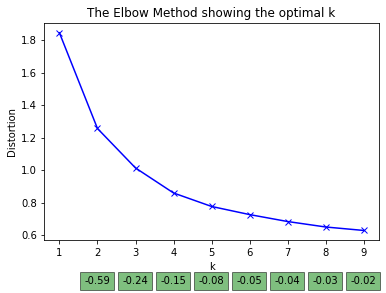

In [27]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
for k in range(1, 9):
    plt.text(k+0.65, 0.3, f"{distortions[k]-distortions[k-1]:.2f}",
             bbox=dict(facecolor='green', alpha=0.5))
plt.show()

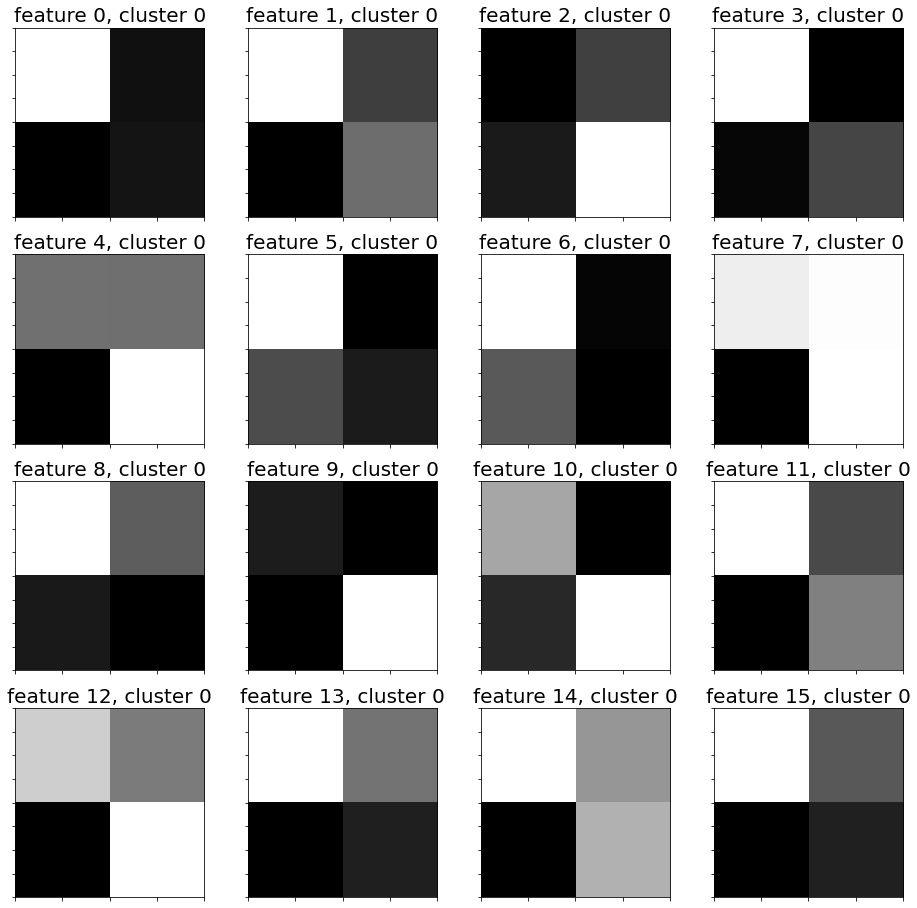

In [28]:
bestkmeans = KMeans(n_clusters=4)
bestkmeans.fit(X)
y_features = bestkmeans.predict(X)
feature_data = pd.DataFrame({"cluster":y_features})
plot_conv_feature(feature_data, X_features, y_features, label=0)

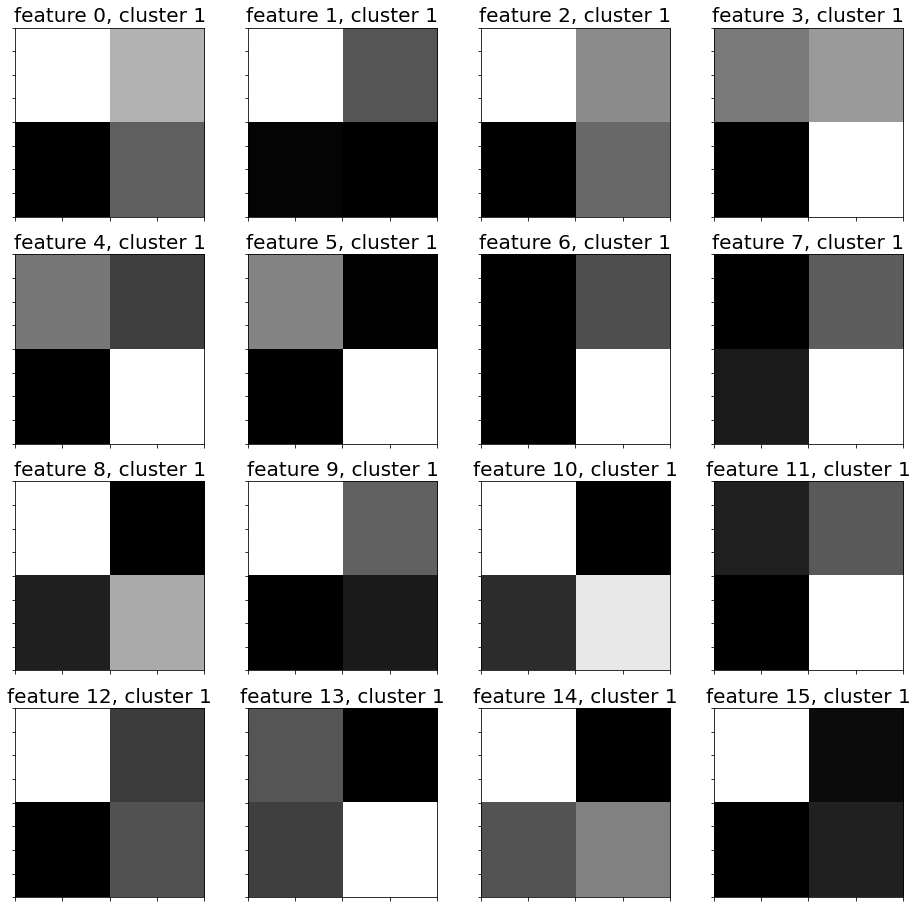

In [29]:
plot_conv_feature(feature_data, X_features, y_features, label=1)

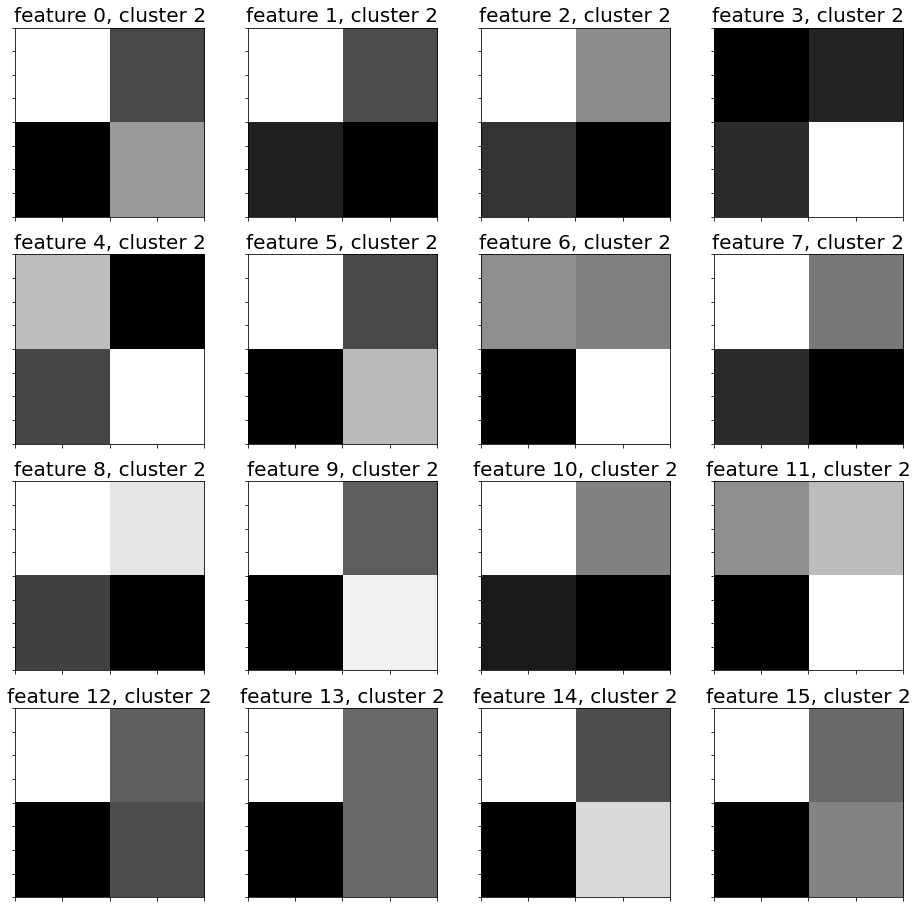

In [30]:
plot_conv_feature(feature_data, X_features, y_features, label=2)

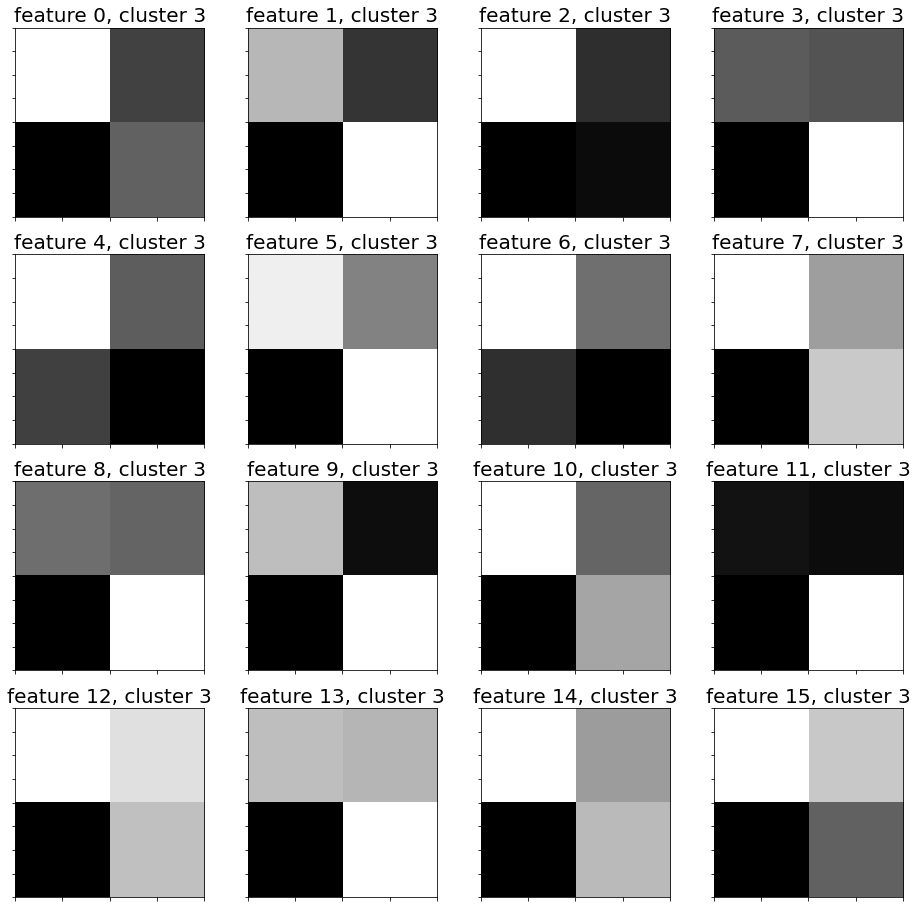

In [31]:
plot_conv_feature(feature_data, X_features, y_features, label=3)